In [1]:
import os

from tensorflow.keras import backend as K
K.clear_session()

import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [13]:
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Concatenate, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img, save_img

import random
import numpy as np
from matplotlib import pyplot as plt

In [23]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/My Drive/Colab Notebooks/martin/fluo'
  # augmented: data_path += '/aug'
except:
  import os
  from pathlib import Path
  here = os.getcwd()  # os.path.abspath(os.path.dirname(__file__))
  data_path = str(Path(here).joinpath('../data/toy/fluo'))

print('getting data from {}, folders there are: {}'.format(data_path, list(os.walk(data_path))[0][1]))

getting data from /home/h4/stfo194b/rp/martin/attila/unet/../data/toy/fluo, folders there are: ['images', 'masks']


In [46]:
image_size = (128, 128)  # original is 1100 x 700
input_shape = (*image_size, 1)
best_model_weights = 'model.h5'

In [58]:
def get_data(imgs_path, masks_path, im_size):
    """ Get and resize train images and masks """

    list_imgs = next(os.walk(imgs_path))[2]
    list_masks = next(os.walk(masks_path))[2]

    X = np.zeros((len(list_imgs), *input_shape), dtype=np.float32)
    y = np.zeros((len(list_imgs), *input_shape), dtype=np.float32)
    
    for i, (img_name, mask_name) in enumerate(zip(list_imgs, list_masks)):
        # load images
        img_path = str(Path(imgs_path).joinpath(img_name))
        img = img_to_array(load_img(img_path, grayscale=True))
        img = resize(img, input_shape, preserve_range=True)
        
        # load masks
        mask_path = str(Path(masks_path).joinpath(mask_name))
        mask = img_to_array(load_img(mask_path, grayscale=True))
        mask = resize(mask, input_shape, preserve_range=True)

        # save images
        X[i, ..., 0] = img.squeeze()
        y[i] = mask / 255

    return X, y

# get data
X, y = get_data(data_path + '/images', data_path + '/masks', image_size)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15)  # split train and test

print('found {} samples: {} training, {} validation'.format(len(X), len(X_train), len(X_valid)))

found 92 samples: 78 training, 14 validation


40

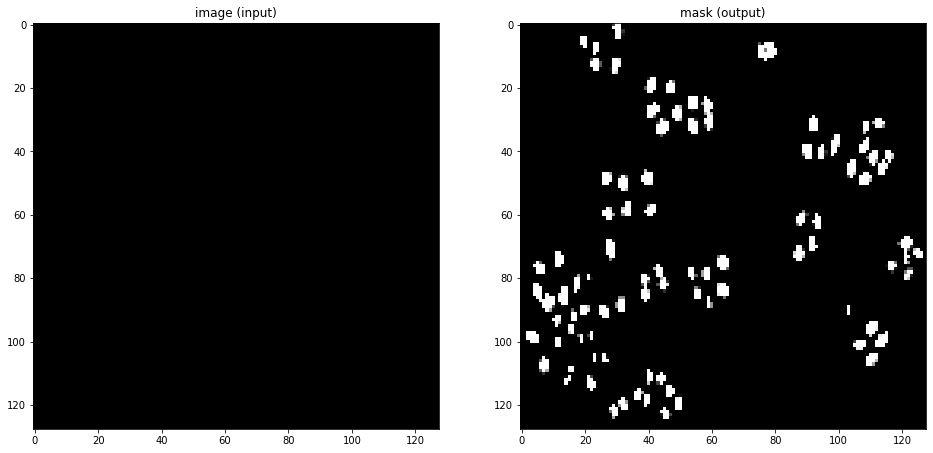

In [59]:
def plot_train_sample(X, y, ix=None):
    if ix is None:
        ix = random.randint(0, len(X) - 1)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].set_title('image (input)')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('mask (output)')

    return ix

def plot_pred_sample(X, y, preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X) - 1)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].contour(y[ix].squeeze(), colors='yellow', levels=[0.5])
    ax[0].set_title('image + mask')

    ax[1].imshow(preds[ix].squeeze(), cmap='gray')
    ax[1].contour(y[ix].squeeze(), colors='yellow', levels=[0.5])
    ax[1].set_title('predicted + original mask')

    return ix

def plot_results(results):
    plt.figure(figsize=(24, 8))

    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    # todo plt.plot(results.history["accuracy"], label="accuracy")
    # todo plt.plot(results.history["val_accuracy"], label="val_acc")
    plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")

    plt.xlabel("epochs")
    plt.ylabel("log loss")
    plt.legend()

plot_train_sample(X_train, y_train)  # check if training data looks all right

In [61]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def get_unet(input_img, n_filters, dropout=0.5, batchnorm=True):
    pooling = MaxPooling2D

    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = pooling((2, 2)) (c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = pooling((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = pooling((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = pooling((2, 2)) (c4)
    p4 = Dropout(dropout)(p4)

    # u path
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[input_img], outputs=[outputs])
    return model

input_img = Input(input_shape, name='img')
model = get_unet(input_img, 64, dropout=0.5, batchnorm=True)

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
# model.summary()

In [64]:
verbose = 1
batch_size = 32
epochs = 100

callbacks = [
    EarlyStopping(patience=10, verbose=verbose),
    ReduceLROnPlateau(factor=1e-1, patience=3, min_lr=1e-5, verbose=verbose),
    ModelCheckpoint(best_model_weights, monitor='loss', verbose=verbose, save_best_only=True, save_weights_only=True)
]
results = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks, validation_data=(X_valid, y_valid))

plot_results(results)

model.load_weights(best_model_weights)  # load best model
model.evaluate(X_valid, y_valid, verbose=verbose)  # evaluate on validation set

preds_train = model.predict(X_train, verbose=verbose)  # predict
preds_val = model.predict(X_valid, verbose=verbose)

Train on 78 samples, validate on 14 samples
Epoch 1/100
64/78 [=======================>......] - ETA: 1s - loss: 0.0169 - acc: 0.9320
Epoch 00001: loss improved from inf to 0.01693, saving model to model.h5
78/78 [==============================] - 11s 146ms/sample - loss: 0.0169 - acc: 0.9314 - val_loss: 0.0542 - val_acc: 0.9267
Epoch 2/100
32/78 [===========>..................] - ETA: 1s - loss: 0.0169 - acc: 0.9343

KeyboardInterrupt: 

/software/generic/JupyterHub/conda-env-20191018-0834/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.
/software/generic/JupyterHub/conda-env-20191018-0834/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: No contour levels were found within the data range.


12

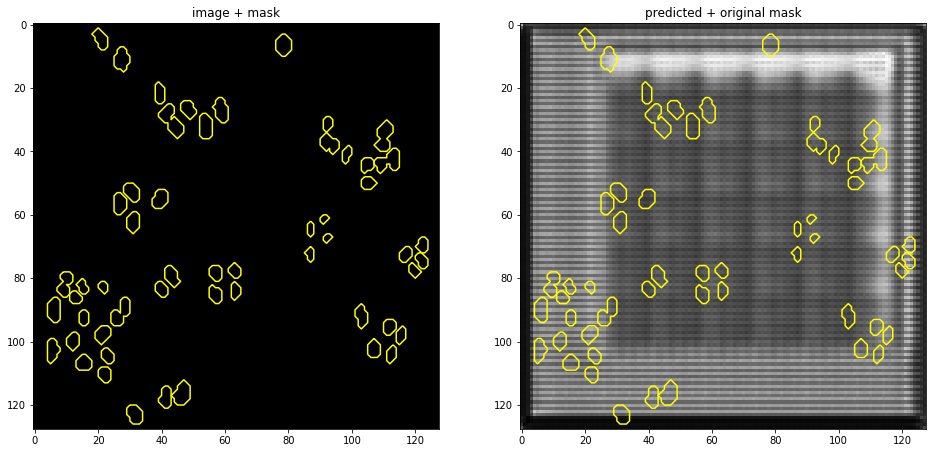

In [63]:
# plot_pred_sample(X_train, y_train, preds_train)  # predictions on training data
plot_pred_sample(X_valid, y_valid, preds_val)  # predictions on test data